# Stock price forecasting

The dataset contains stock market data of Amazon.com, Inc(AMZN) and it can be downloaded from Yahoo Finance.

The data shows the stock price of Amazon.com, Inc(AMZN) from 2011-01-01 till 2017–11–10. The goal is to train an ARIMA model with optimal parameters that will forecast the closing price of the stocks on the test data.

In [1]:
COMPANY_NAME = 'Amazon.com, Inc'
STOCK_TICKER = 'AMZN'
START_DATE = '2011-01-01'
END_DATE = '2021-05-31'

### Import Libraries

In [61]:
import os
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

**Load the stock closing prices data**

In [3]:
ticker_df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
ticker_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,181.369995,186.000000,181.210007,184.220001,184.220001,5331400
2011-01-04,186.149994,187.699997,183.779999,185.009995,185.009995,5031800
2011-01-05,184.100006,187.449997,184.070007,187.419998,187.419998,3418800
2011-01-06,186.500000,187.410004,185.250000,185.860001,185.860001,3179700
2011-01-07,187.880005,188.449997,183.740005,185.490005,185.490005,5221700
...,...,...,...,...,...,...
2021-05-24,3215.500000,3257.949951,3210.500000,3244.989990,3244.989990,2422800
2021-05-25,3266.669922,3279.820068,3213.760010,3259.050049,3259.050049,3261100
2021-05-26,3274.590088,3295.729980,3258.510010,3265.159912,3265.159912,2384000


**Plot closing price of the stock from the dataframe**

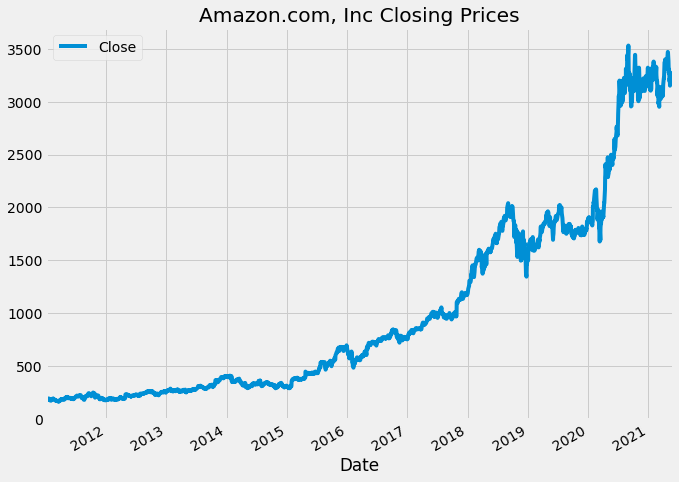

In [4]:
ticker_df['Close'].plot(
    title=COMPANY_NAME+' Closing Prices', 
    legend='Close', 
    figsize=(10, 8))
plt.margins(x=0)

From the above graph, we observe an upwards trend. As we know, a time series with an upward or downward trend is non-stationary. So, First, we need to check if a series is stationary or not because time series analysis only works with stationary data. 

We can use one of most popular statistical test called ADF(Augmented Dickey-Fuller)Test. It can be used to test whether a given time series is stationary or not by determing the presence of unit root in the series.
The null and alternate hypothesis of this test is:

- Null Hypothesis: The series has a unit root (value of a =1)

- Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

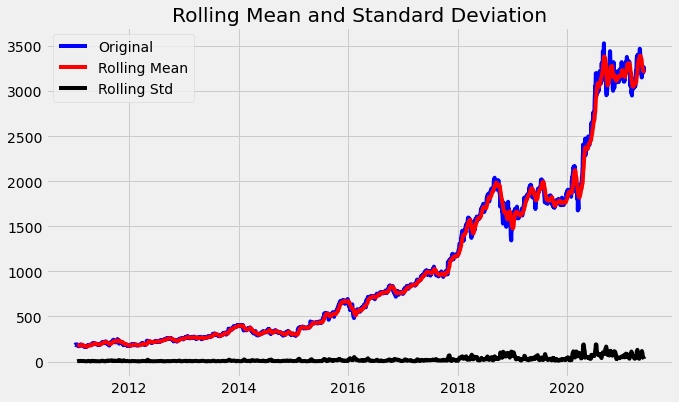

Results of dickey fuller test
Test Statistics                   1.828993
p-value                           0.998405
No. of lags used                 27.000000
Number of observations used    2591.000000
critical value (1%)              -3.432876
critical value (5%)              -2.862656
critical value (10%)             -2.567364
dtype: float64


In [5]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(ticker_df['Close'])

**Observations**

From the above test results, we can observe the following:

- p-value is greater than the significance value 0.05. So, we cannot reject the null hypothesis.
- test statistics is also greater than the critical value.

Therefore, the time series data is non-stationary.

**Decomposition**

A time series consists of three systematic components(a time series that have consistency and can be described and modeled) including level, trend, seasonality, and one non-systematic component(that cannot be directly modeled) called noise. To analyze the time series data, we need to separate the trend, seasonality and noise.

These components are defined as follows:

- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series. 

<Figure size 720x432 with 0 Axes>

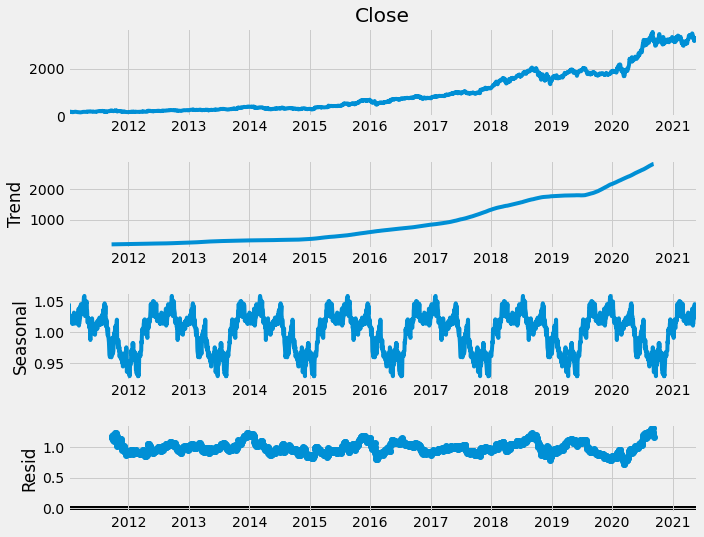

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ticker_df['Close'], model='multiplicative', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 8)

To reduce the magnitude of the values and the rising trend in the series, we use log of the series.

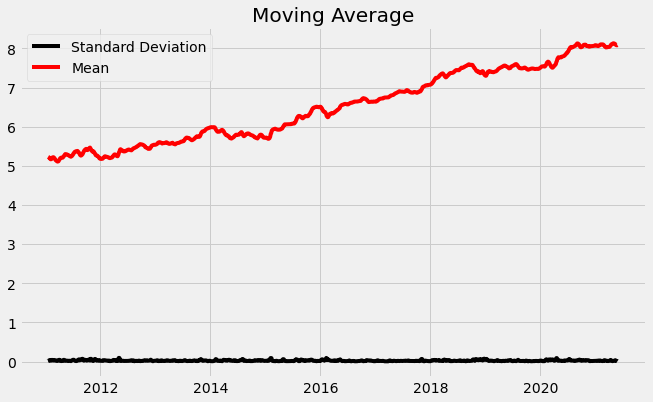

In [7]:
ticker_log_df = np.log(ticker_df['Close'])
moving_avg = ticker_log_df.rolling(12).mean()
std_dev = ticker_log_df.rolling(12).std()
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

<Figure size 720x432 with 0 Axes>

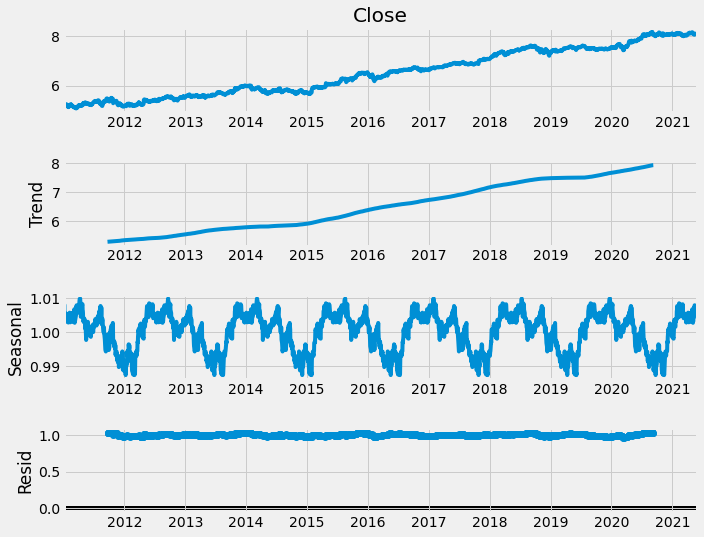

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ticker_log_df, model='multiplicative', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 8)

### Forecasting the Close Price using an ARIMA Model

Using the Close Price, estimate an ARIMA model. First, we need to choose the parameters(p,d,q) of the model. There are so many ways to find the parameters. We use the following:

- ACF and PACF

- Auto ARIMA

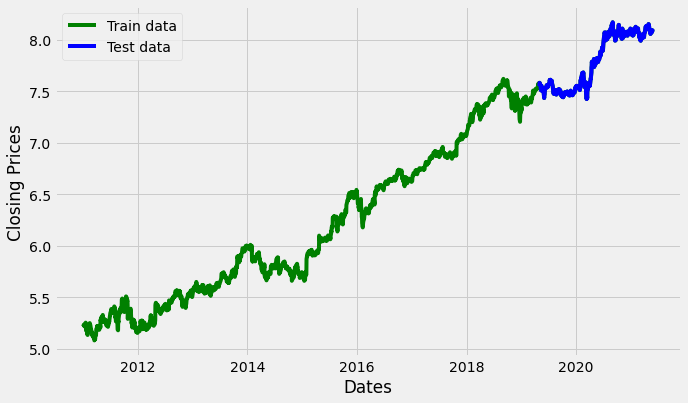

In [9]:
# Split the data set into a 80% for training and 20% for testing
split_data = int(len(ticker_log_df)*0.8)

train_data = ticker_log_df[0:split_data]
test_data = ticker_log_df[split_data:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(ticker_log_df, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [217]:
def plot_predictions(predictions):
    pred_series = pd.Series(predictions[:len(test_data)], index=test_data.index)
    plt.figure(figsize=(15,10), dpi=50)
    plt.plot(train_data, label='training')
    plt.plot(test_data, color = 'blue', label='Actual Stock Price')
    plt.plot(pred_series, color = 'orange',label='Predicted Stock Price')
    plt.title(COMPANY_NAME+' Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Actual Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [201]:
def performance_report(predictions):
    pred = predictions[:len(test_data)]
    # report performance
    mse = mean_squared_error(test_data, pred)
    print('MSE: '+str(mse))
    mae = mean_absolute_error(test_data, pred)
    print('MAE: '+str(mae))
    rmse = math.sqrt(mean_squared_error(test_data, pred))
    print('RMSE: '+str(rmse))
    mape = np.mean(np.abs(pred - test_data)/np.abs(test_data))
    print('MAPE: '+str(mape))

###  1. Autocorrelation Function and Partial Autocorrelation Function Analysis

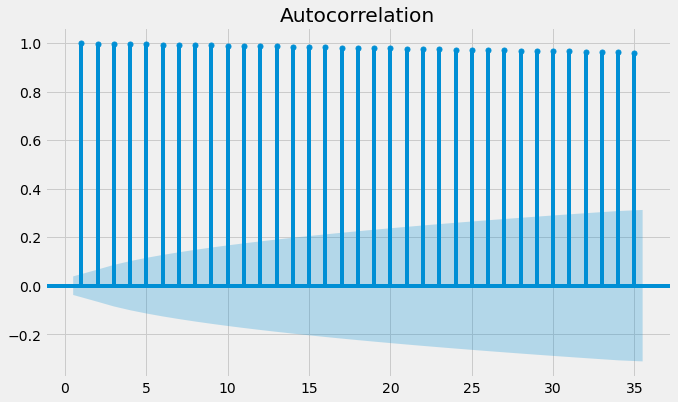

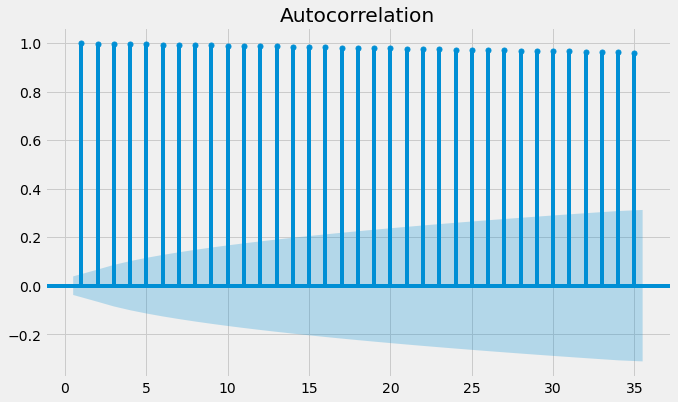

In [202]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the autocorrelation of the Settle Prices
plot_acf(ticker_log_df, zero=False, lags=35)

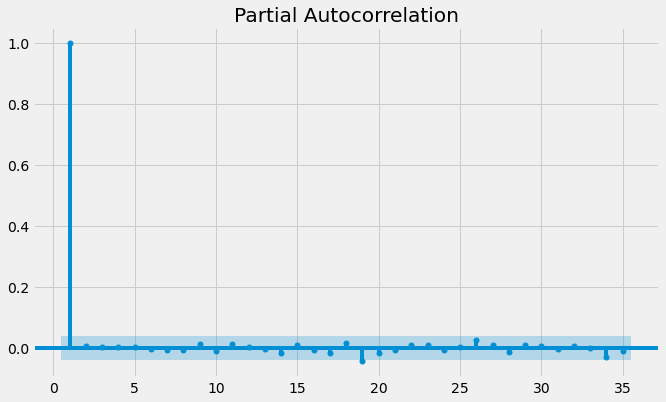

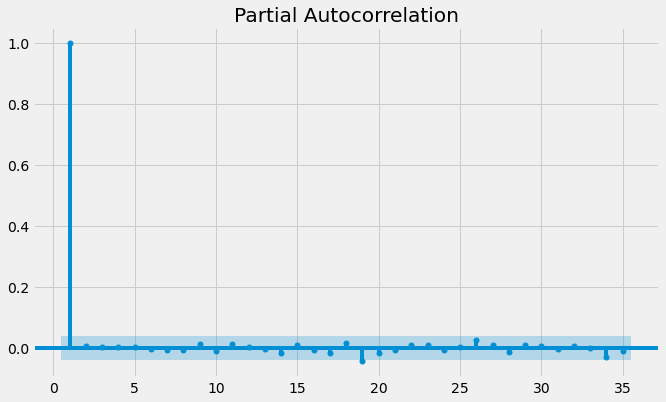

In [203]:
# Plot the partial autocorrelation 
plot_pacf(ticker_log_df, zero=False, lags=35)

### Build Arima model 

Using the Close Price, estimate an ARIMA model. Set P=1, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(1,1,1)) P= parameter of Auto-Regressive Lag 1, D= parameter of Differences 1 (this is usually =1), Q= parameter of Moving Average Lag of 1

In [204]:
arima_model = ARIMA(train_data, order=(1,1,1))
arima_fit = arima_model.fit(disp=0)
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2094
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5250.034
Method:                       css-mle   S.D. of innovations              0.020
Date:                Mon, 07 Jun 2021   AIC                         -10492.069
Time:                        12:51:54   BIC                         -10469.481
Sample:                             1   HQIC                        -10483.794
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.000      3.293      0.001       0.000       0.002
ar.L1.D.Close     0.9017      0.091      9.955      0.000       0.724       1.079
ma.L1.D.Close    -0.9226      0.081    -11.391      0.000      -1.081      -0.764
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1090           +0.0000j            1.1090            0.0000
MA.1            1.0838           +0.0000j            1.0838            0.0000
-----------------------------------------------------------------------------
"""

In [222]:
predictions1,_,_ = arima_fit.forecast(len(test_data))

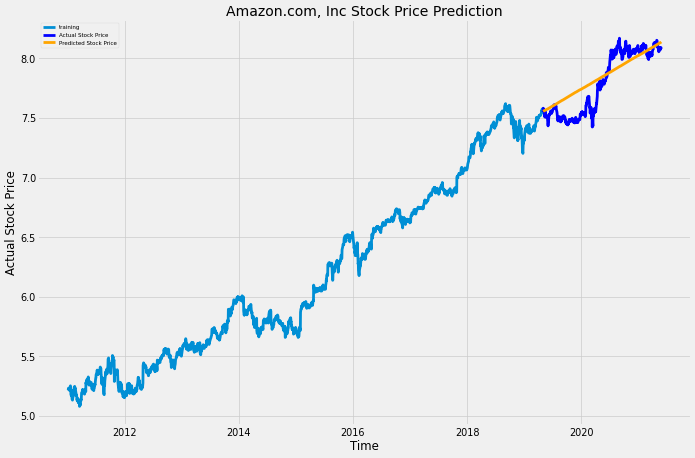

In [218]:
plot_predictions(predictions1)

In [207]:
performance_report(predictions1)

MSE: 0.019166053721613098
MAE: 0.11235622953029838
RMSE: 0.13844151733354088
MAPE: 0.014618158542462161


## 2. Auto Arima

The `auto_arima` function automatically obtains the optimal parameters of the model and fits the best ARIMA model to a univariate time series according to either AIC, AICc, BIC or HQIC. The function performs a search over possible model orders within the constraints provided.

In [208]:
autoarima_model = auto_arima(
    train_data, 
    start_p=0, 
    start_q=0,
    test='adf',       # use adftest to find optimal 'd'
    max_p=3, max_q=3, # maximum p and q
    m=1,              # frequency of series
    d=None,           # let model determine 'd'
    seasonal=True,   # No Seasonality
    start_P=0, 
    D=0, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
print(autoarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10491.150, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10489.211, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10489.215, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10486.454, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10491.355, Time=0.90 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10490.198, Time=0.98 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10489.671, Time=1.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-10490.065, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10489.861, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10487.678, Time=0.87 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-10484.327, Time=0.29 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 5.545 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observati

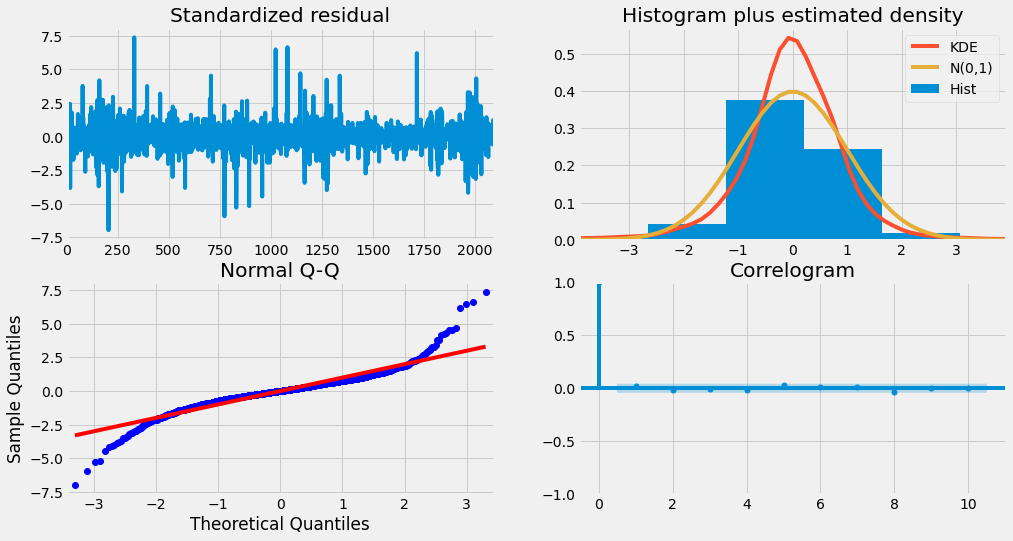

In [209]:
autoarima_model.plot_diagnostics(figsize=(15,8))
plt.show()

From the above plot, we can observe that:

In standardized residual plot, residual error fluctuates around the mean of zero and the variance become constant.

In Histogram density plot, we see the normal distribution with mean zero.

The Normal Q-Q figure suggest that there is some significant deviation.

The correlogram(ACF) plot shows that there is some autocorrelation.

In [210]:
predictions2 = autoarima_model.predict(len(test_data))

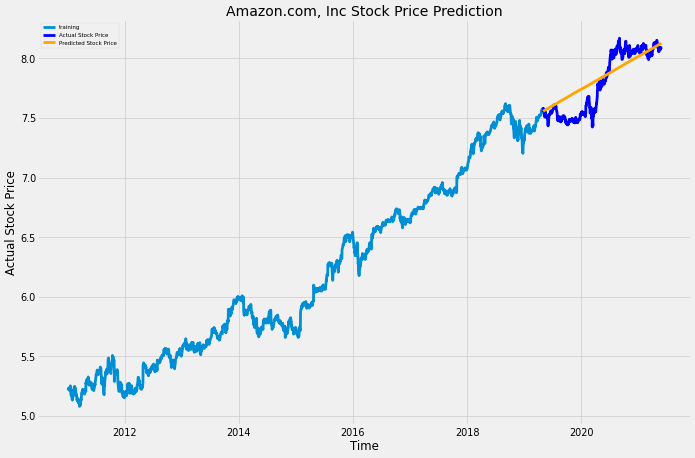

In [219]:
plot_predictions(predictions2)

**Observation:**

The graph above shows the forecasts of the closing price for next d days, where d is the number of datapoints of the test data. As we can see, the predictions form a straight line. This is because we do not retrain the model when new data points are available. That means the model is trained on datapoints `t0, ...tn-1` and is used to predict for d days `tn, tn+1, ...tn+d`. 

In [212]:
performance_report(predictions2)

MSE: 0.019396010687018534
MAE: 0.11374044709031775
RMSE: 0.1392695612365406
MAPE: 0.014789884197708292


## 3. Rolling Forecast 

In [213]:
def daily_forecast(train, num_days):
    autoarima_model = auto_arima(
        train, start_p=0, start_q=0,
        test='adf',       # use adftest to find optimal 'd'
        max_p=2, max_q=2, # maximum p and q
        m=1,              # frequency of series
        d=None,           # let model determine 'd'
        seasonal=False,   # No Seasonality
        start_P=0, 
        D=0, 
        trace=False,
        error_action='ignore',  
        suppress_warnings=True, 
        stepwise=True)
    return autoarima_model.predict(num_days)

In [214]:
def rolling_forecast(step=1):
    train_tmp = train_data
    predictions = []
    for i in range(0, len(test_data), step):
        print('.', end='')
        predictions.extend(daily_forecast(train_tmp, step))
        train_tmp = train_tmp.append(test_data[i:(i+step)])
    return predictions

In [215]:
predictions3 = rolling_forecast(5)

.........................................................................................................

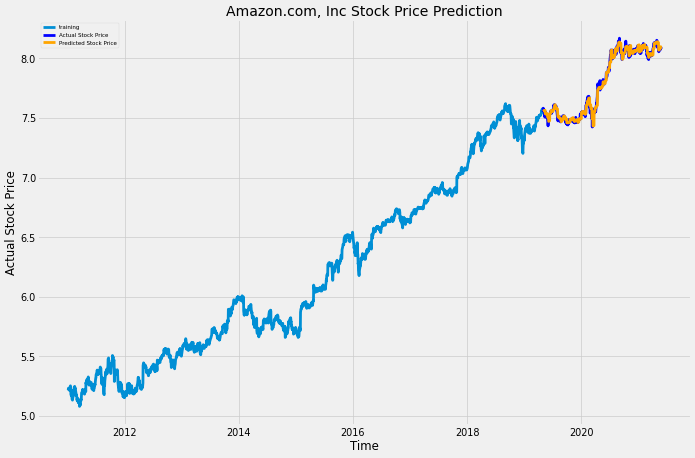

In [220]:
plot_predictions(predictions3)

Observation:

The graph above shows the forecast of the closing price for next n days, where n is the number of datapoints of the test data. As we can see, the predictions are very accurate. In this case, we retrain the model when new datapoints are available. That means the model is first trained on datapoints `t0, ...tn-1` and is used to predict `tn`. Once the actual `tn` is available, the model is retrained on data `t0, ...tn` and predicts `tn+1` and so on.

In [27]:
performance_report(predictions3)

MSE: 0.0008579529961930821
MAE: 0.021680933415268774
RMSE: 0.02929083467900978
MAPE: 0.0027803482965084838


- MSE(mean squared error) is used to measure the average of the squares of the errors that means it checks how close forecast values are to actual values. The lower value indicates better fit.

- MAE(mean absolute error) measures the absolute average distance between the real data and the predicted data. As we can see mean absolute error is 0.021, that means the forecast's distance from the actual value is 0.021. Average magnitude of the errors in a set of forecasts, without considering their direction. It measures accuracy for continuous variables.

- RMSE(root mean squared error) measures the square root of the variances. The lower value of MSE and RMSE implies higher accuracy the model. 

- 0.27% of MAPE(Mean Absolute Percentage Error) implies the model is about 95.5% accurate in predicting the test set observations. As we know MAPE < 10% is Excellent, MAPE < 20% is Good. 


## 4. Rolling Forecast with Correlated Assets

### Loading the data

In this project, we have used supervised learning models to predict a stock price. The weekly return of Amazon stock is the predicted variable. We need to find out what else affects the Amazon stock price and Incorporate the other features that are useful for stock price prediction into the model.
For independent variable, we are using historical data of Amazon and correlated assets that are:

Stocks: Apple Inc.(AAPL) and Alphabet Inc.(GOOG)

Currency: USD/JPY(JPY=X) and USD/EUR(EUR=X)

Indices: SPDR S&P 500 ETF Trust(SPY) and Dow Jones Industrial Average(^DJI)

The dataset used for this project is extracted from Yahoo Finance website.

In [28]:
stk_tickers = [STOCK_TICKER, 'AAPL', 'GOOG']
ccy_tickers = ['JPY=X', 'EUR=X']
idx_tickers = ['^GSPC', '^DJI']

stk_data = yf.download(stk_tickers, start=START_DATE, end=END_DATE)
ccy_data = yf.download(ccy_tickers, start=START_DATE, end=END_DATE)
idx_data = yf.download(idx_tickers, start=START_DATE, end=END_DATE)

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


In [29]:
stk_data.head()

Adj Close                              Close              \
                 AAPL        AMZN        GOOG       AAPL        AMZN   
Date                                                                   
2011-01-03  10.121364  184.220001  301.046600  11.770357  184.220001   
2011-01-04  10.174186  185.009995  299.935760  11.831786  185.009995   
2011-01-05  10.257413  187.419998  303.397797  11.928571  187.419998   
2011-01-06  10.249121  185.860001  305.604523  11.918929  185.860001   
2011-01-07  10.322517  185.490005  307.069031  12.004286  185.490005   

                             High                                Low  \
                  GOOG       AAPL        AMZN        GOOG       AAPL   
Date                                                                   
2011-01-03  301.046600  11.795000  186.000000  301.664276  11.601429   
2011-01-04  299.935760  11.875000  187.699997  301.958191  11.719643   
2011-01-05  303.397797  11.940714  187.449997  304.025452  11.767857   
2011-01-06  305.604523  11.973214  187.410004  308.060303  11.889286   
2011-01-07  307.069031  12.012500  188.449997  307.970642  11.853571   

                                         Open                          \
                  AMZN        GOOG       AAPL        AMZN        GOOG   
Date                                                                    
2011-01-03  181.210007  297.126312  11.630000  181.369995  297.126312   
2011-01-04  183.779999  298.939514  11.872857  186.149994  301.679230   
2011-01-05  184.070007  298.904633  11.769643  184.100006  298.914581   
2011-01-06  185.250000  303.885956  11.954286  186.500000  304.199799   
2011-01-07  183.740005  303.925812  11.928214  187.880005  306.805023   

               Volume                    
                 AAPL     AMZN     GOOG  
Date                                     
2011-01-03  445138400  5331400  4748131  
2011-01-04  309080800  5031800  3662677  
2011-01-05  255519600  3418800  5083583  
2011-01-06  300428800  3179700  4131026  
2011-01-07  311931200  5221700  4218152

In [30]:
ccy_data.head()

Adj Close               Close                High             \
               EUR=X      JPY=X    EUR=X      JPY=X    EUR=X      JPY=X   
Date                                                                      
2011-01-03   0.74862  81.123001  0.74862  81.123001  0.75455  81.709000   
2011-01-04   0.74868  81.669998  0.74868  81.669998  0.75085  82.267998   
2011-01-05   0.75069  82.038002  0.75069  82.038002  0.76167  83.320000   
2011-01-06   0.76006  83.189003  0.76006  83.189003  0.76724  83.376999   
2011-01-07   0.77042  83.300003  0.77042  83.300003  0.77286  83.657997   

                Low                Open            Volume        
              EUR=X      JPY=X    EUR=X      JPY=X  EUR=X JPY=X  
Date                                                             
2011-01-03  0.74822  81.120003  0.74873  81.139999    0.0   0.0  
2011-01-04  0.74455  81.599998  0.74850  81.671997    0.0   0.0  
2011-01-05  0.75053  81.883003  0.75053  82.010002    0.0   0.0  
2011-01-06  0.75928  82.879997  0.75982  83.160004    0.0   0.0  
2011-01-07  0.76797  82.947998  0.76988  83.269997    0.0   0.0

In [31]:
idx_data.head()

Adj Close                      Close               \
                    ^DJI        ^GSPC          ^DJI        ^GSPC   
Date                                                               
2011-01-03  11670.750000  1271.869995  11670.750000  1271.869995   
2011-01-04  11691.179688  1270.199951  11691.179688  1270.199951   
2011-01-05  11722.889648  1276.560059  11722.889648  1276.560059   
2011-01-06  11697.309570  1273.849976  11697.309570  1273.849976   
2011-01-07  11674.759766  1271.500000  11674.759766  1271.500000   

                    High                        Low               \
                    ^DJI        ^GSPC          ^DJI        ^GSPC   
Date                                                               
2011-01-03  11711.469727  1276.170044  11577.349609  1257.619995   
2011-01-04  11698.219727  1274.119995  11635.740234  1262.660034   
2011-01-05  11742.679688  1277.630005  11652.889648  1265.359985   
2011-01-06  11736.740234  1278.170044  11667.459961  1270.430054   
2011-01-07  11726.940430  1276.829956  11599.679688  1261.699951   

                    Open                  Volume              
                    ^DJI        ^GSPC       ^DJI       ^GSPC  
Date                                                          
2011-01-03  11577.429688  1257.619995  203420000  4286670000  
2011-01-04  11670.900391  1272.949951  178630000  4796420000  
2011-01-05  11688.610352  1268.780029  169990000  4764920000  
2011-01-06  11716.929688  1276.290039  193080000  4844100000  
2011-01-07  11696.860352  1274.410034  188720000  4963110000

Define X and Y features.

For dependent variable(Y), the predicted variable is the weekly return of Company's stock. The number of trading days in a week is 5 and we compute the return using 5 trading days.

For independent variable(X), we use the correlated assets and the historical return of Company's stock at different time period.

In [32]:
return_period = 5

In [33]:
X1 = np.log(stk_data.loc[:, ('Close', ('AAPL', 'GOOG'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data['Close']).diff(return_period)
X3 = np.log(idx_data['Close']).diff(return_period)
X4 = pd.concat([np.log(stk_data.loc[:, ('Close', 'AMZN')]).diff(r) for r in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['AMZN_Lag', 'AMZN_3Lag', 'AMZN_6Lag', 'AMZN_12Lag']


X = pd.concat([X1, X2, X3, X4], axis=1)
Y = np.log(stk_data.loc[:, ('Close', 'AMZN')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

df = pd.concat([X, Y], axis=1).dropna().iloc[::return_period, :]
X = df.loc[:, X.columns]
Y = df.loc[:, Y.name]

df.head()

,AAPL,GOOG,EUR=X,JPY=X,^DJI,^GSPC,AMZN_Lag,AMZN_3Lag,AMZN_6Lag,AMZN_12Lag,AMZN_pred
Date,,,,,,,,,,,
2011-03-30,0.027451,-0.000550,0.004030,0.016788,0.021656,0.023400,0.081846,0.059535,-0.052176,-0.026401,0.018444
2011-04-06,-0.030847,-0.013252,-0.007621,0.032813,0.006146,0.005466,0.018444,0.104048,0.033834,-0.010451,-0.002575
2011-04-13,-0.005666,0.003651,-0.017934,-0.018488,-0.012613,-0.015948,-0.002575,0.097716,0.057988,-0.047983,0.008630
2011-04-21,0.053532,-0.096867,-0.004966,-0.016159,0.017817,0.017241,0.022138,0.031476,0.112324,0.058143,0.051990
2011-04-29,-0.001627,0.035544,-0.019667,-0.004491,0.024061,0.019423,0.051990,0.057276,0.195927,0.120794,0.009100


In [198]:
df.to_csv('Resources/df.csv')

<AxesSubplot:xlabel='Date'>

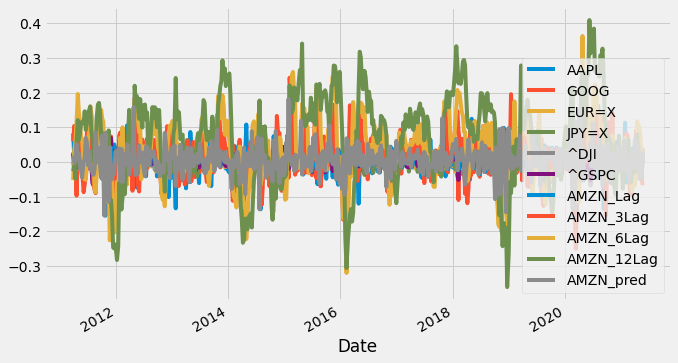

In [34]:
df.plot()

In [35]:
df.describe()

,AAPL,GOOG,EUR=X,JPY=X,^DJI,^GSPC,AMZN_Lag,AMZN_3Lag,AMZN_6Lag,AMZN_12Lag,AMZN_pred
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,0.004570,0.004178,0.000206,0.000555,0.002092,0.002358,0.006063,0.017898,0.035316,0.069266,0.005730
std,0.039097,0.035399,0.011624,0.011980,0.022911,0.022460,0.041443,0.068654,0.092314,0.124933,0.041283
min,-0.165544,-0.168131,-0.046073,-0.048019,-0.208720,-0.198044,-0.154424,-0.250135,-0.319624,-0.360259,-0.154424
25%,-0.018052,-0.015739,-0.006745,-0.005808,-0.006845,-0.005653,-0.017900,-0.021060,-0.022631,-0.014537,-0.018161
50%,0.005965,0.005353,0.000600,0.000034,0.003286,0.003804,0.006562,0.017852,0.038343,0.078145,0.006479
75%,0.027000,0.024304,0.006986,0.007109,0.013890,0.014025,0.029085,0.060514,0.096689,0.150082,0.028152
max,0.162119,0.167087,0.037628,0.063411,0.115749,0.098984,0.181664,0.242868,0.362944,0.409095,0.181664


In [36]:
X.head()

,AAPL,GOOG,EUR=X,JPY=X,^DJI,^GSPC,AMZN_Lag,AMZN_3Lag,AMZN_6Lag,AMZN_12Lag
Date,,,,,,,,,,
2011-03-30,0.027451,-0.000550,0.004030,0.016788,0.021656,0.023400,0.081846,0.059535,-0.052176,-0.026401
2011-04-06,-0.030847,-0.013252,-0.007621,0.032813,0.006146,0.005466,0.018444,0.104048,0.033834,-0.010451
2011-04-13,-0.005666,0.003651,-0.017934,-0.018488,-0.012613,-0.015948,-0.002575,0.097716,0.057988,-0.047983
2011-04-21,0.053532,-0.096867,-0.004966,-0.016159,0.017817,0.017241,0.022138,0.031476,0.112324,0.058143
2011-04-29,-0.001627,0.035544,-0.019667,-0.004491,0.024061,0.019423,0.051990,0.057276,0.195927,0.120794


In [37]:
Y.head()

Date
2011-03-30    0.018444
2011-04-06   -0.002575
2011-04-13    0.008630
2011-04-21    0.051990
2011-04-29    0.009100
Name: AMZN_pred, dtype: float64

### Exploratory data analysis
### Data visualization

<AxesSubplot:title={'center':'Correlation Matrix'}>

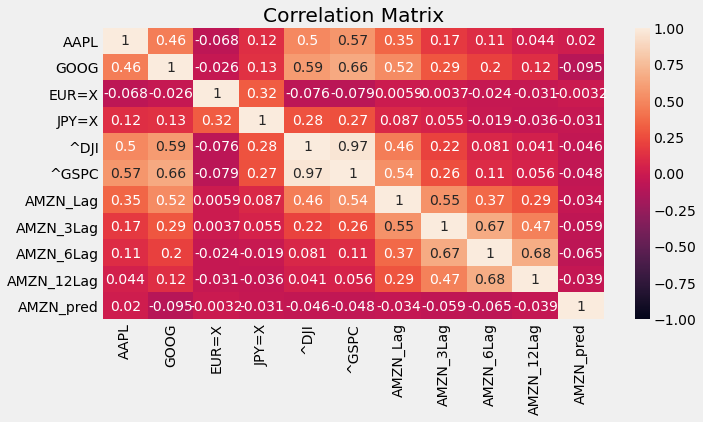

In [38]:
correlation = df.corr()
plt.figure(figsize=(10,5))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True)

<Figure size 720x360 with 0 Axes>

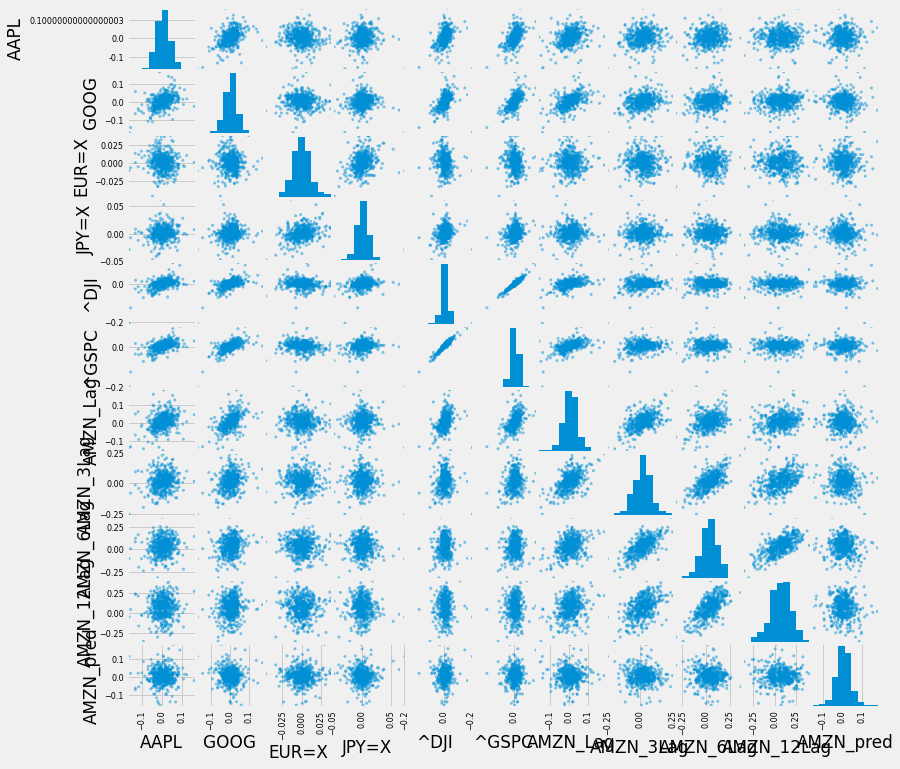

In [39]:
plt.figure(figsize=(10,5))
scatter_matrix(df, figsize=(12, 12))
plt.show()

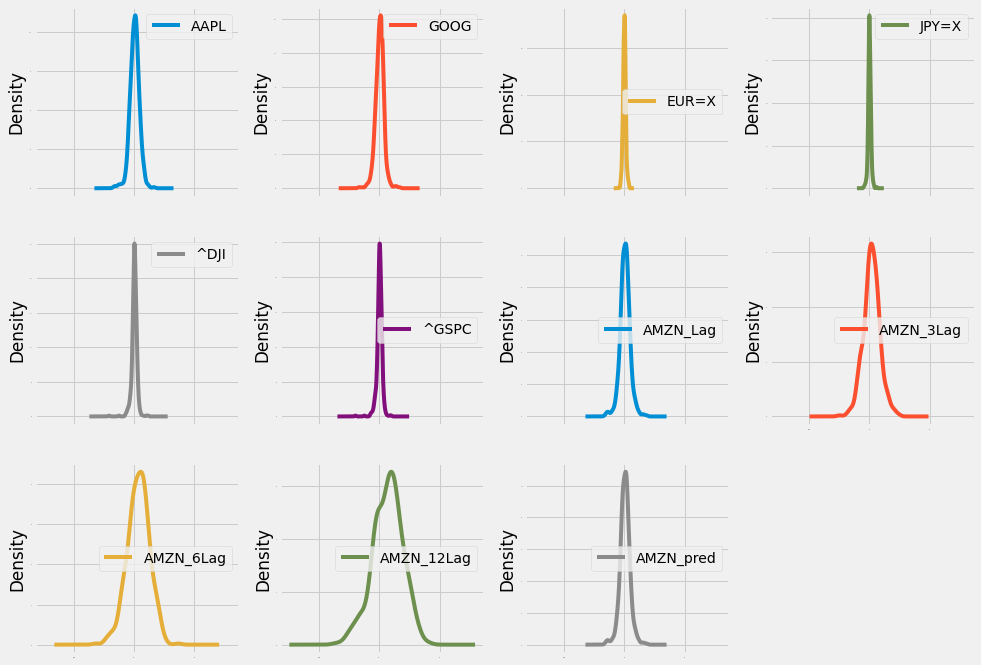

In [40]:
df.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
plt.show()

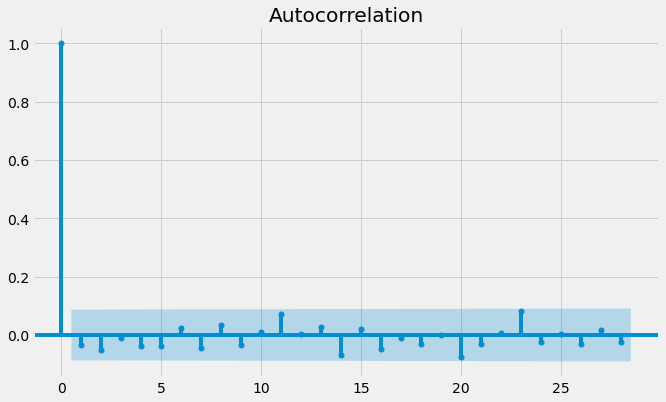

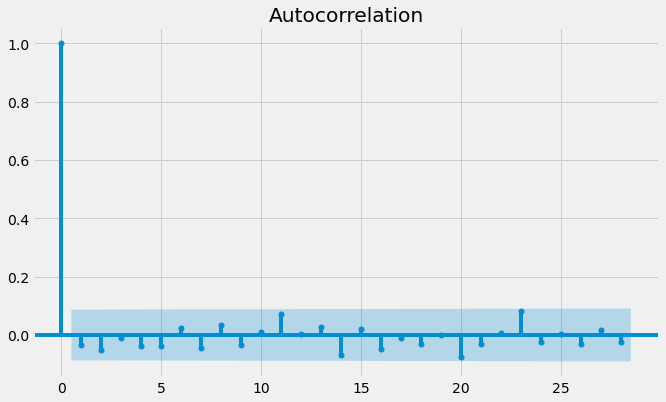

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the autocorrelation of the Closing Prices
plot_acf(df['AMZN_pred'])

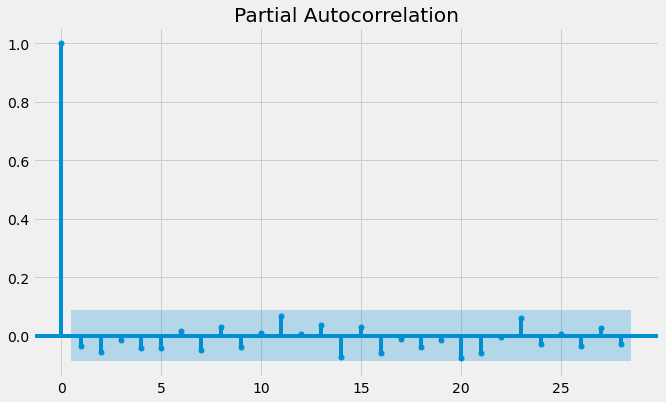

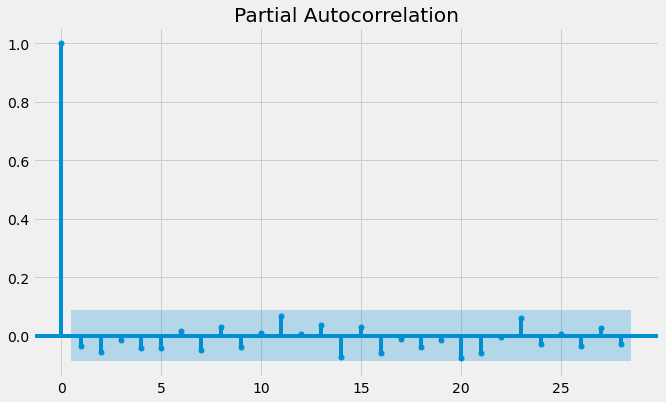

In [42]:
plot_pacf(df['AMZN_pred'])

### Time Series Analysis

Decomposition of the time series of the predicted variable into trend and seasonality components:

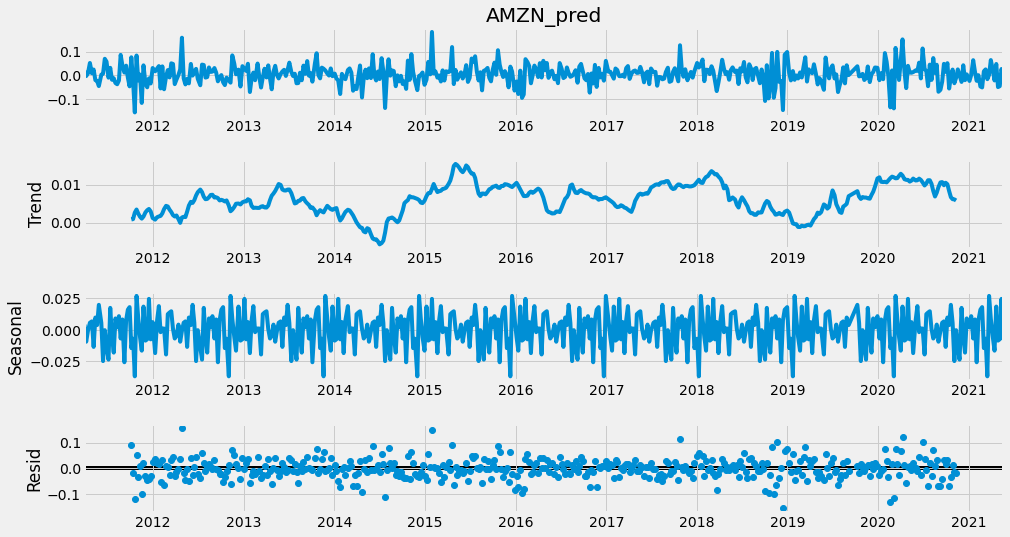

In [43]:
result = sm.tsa.seasonal_decompose(Y, model='additive', freq=52)
figure = result.plot()
figure.set_figheight(8)
figure.set_figwidth(15)
plt.show()

### Evaluate models

In this section, you will need to prepare the training and testing data for the model. The test set is a sample of the data that we use it at the end of our project to confirm the performance of our final model. We will use 80% of the dataset for modeling and use 20% for testing.

In [44]:
split = int(.8 * len(X))
X_train, X_test = X[:split], X[split:len(X)]
Y_train, Y_test = Y[:split], Y[split:len(X)]

## Time Series based models-ARIMA
Let us first prepare the dataset for ARIMA models, by having only the correlated variables as exogenous variables.

### Time Series Model - ARIMA Model

In [45]:
X_train_ARIMA = X_train.loc[:, ['AAPL', 'GOOG', 'EUR=X', 'JPY=X', '^DJI', '^GSPC']]
X_test_ARIMA = X_test.loc[:, ['AAPL', 'GOOG', 'EUR=X', 'JPY=X', '^DJI', '^GSPC']]

In [46]:
X_train_ARIMA.head()

,AAPL,GOOG,EUR=X,JPY=X,^DJI,^GSPC
Date,,,,,,
2011-03-30,0.027451,-0.000550,0.004030,0.016788,0.021656,0.023400
2011-04-06,-0.030847,-0.013252,-0.007621,0.032813,0.006146,0.005466
2011-04-13,-0.005666,0.003651,-0.017934,-0.018488,-0.012613,-0.015948
2011-04-21,0.053532,-0.096867,-0.004966,-0.016159,0.017817,0.017241
2011-04-29,-0.001627,0.035544,-0.019667,-0.004491,0.024061,0.019423


In [47]:
# Import the ARIMA model
from statsmodels.tsa.arima_model import ARIMA

# Configure ARIMA model with the order of (p, d, q)=(1,0,0) and use the independent 
# variables as the exogenous variables in the model. The ARIMA model where the exogenous variables are used is known as the ARIMAX model, where 
# 'X' represents exogenous variable.
model_ARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=(1,0,0))
model_fit = model_ARIMA.fit()

/Users/soma/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [48]:
predictions = model_fit.predict(start = len(X_train_ARIMA)-1, end = len(X)-1, exog=X_test_ARIMA)[1:]
predictions

/Users/soma/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


404    0.001734
405    0.006402
406    0.018953
407    0.001587
408    0.001662
         ...   
501    0.005355
502    0.000857
503    0.002548
504    0.005446
505    0.004926
Length: 102, dtype: float64

In [49]:
from math import sqrt
from sklearn.metrics import mean_squared_error
mse_Test_ARIMA = mean_squared_error(Y_test, predictions)
rmse_Test_ARIMA = sqrt(mean_squared_error(Y_test, predictions))
print(f"The mean squared error and the root mean squared error of the ARIMA model is {mse_Test_ARIMA} and {rmse_Test_ARIMA}")

The mean squared error and the root mean squared error of the ARIMA model is 0.001991000435926601 and 0.04462062791945672


As we know, mean squared error(MSE) is the average of the squares of the errors that is the average squared difference between the original and predicted values and root mean squared error(RMSE) is the square root of mean square error. The lower value of MSE and RMSE implies higher accuracy of a regression model.

**Lets perform the model tuning of the ARIMA model**

In [104]:
def evaluate_arima_model(arima_order):
    model_arima = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=arima_order)
    model_fit = model_arima.fit()
#     pred = model_fit.predict(len(X_test_ARIMA))
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

In [105]:
# Evaluate combination of p, d and q values for an ARIMA model

def evaluate_models(p_values, d_values, q_values):
    # float('inf') sets the value as +ve infinity
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                arima_order = (p,d,q)
                try:
                    mse = evaluate_arima_model(arima_order)
                    if mse < best_score:
                        best_score, best_cfg = mse, arima_order
                    print("ARIMA%s MSE=%.7f" % (arima_order, mse))
                except:
                    continue
    print("Best ARIMA%s MSE=%.7f" % (best_cfg, best_score))

In [189]:
# Evaluate parameters

p_values = [0, 1, 2]
d_values = range(0,2)
q_values = range(0,2)

evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0016089
ARIMA(0, 0, 1) MSE=0.0016081
ARIMA(1, 0, 0) MSE=0.0016083
ARIMA(1, 0, 1) MSE=0.0015929
ARIMA(2, 0, 0) MSE=0.0016018
ARIMA(2, 0, 1) MSE=0.0015947
Best ARIMA(1, 0, 1) MSE=0.0015929


In [190]:
# Finalize the model on the test data
# Prepare the model
model_ARIMA_tuned = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=(1,0,1))
model_fit_tuned = model_ARIMA_tuned.fit()

In [191]:
# Estimate accuracy on the validation set
predicted_tuned = model_fit_tuned.predict(start = len(X_train_ARIMA)-1, end = len(X)-1, exog=X_test_ARIMA)[1:]
print(mean_squared_error(Y_test, predicted_tuned))

0.001974653106046716


In [192]:
Y_test

Date
2019-04-18    0.046668
2019-04-26    0.006046
2019-05-03   -0.037633
2019-05-10   -0.011163
2019-05-17   -0.024766
                ...   
2021-04-22    0.047874
2021-04-29   -0.048681
2021-05-06   -0.044814
2021-05-13    0.026904
2021-05-20   -0.005425
Name: AMZN_pred, Length: 102, dtype: float64

In [193]:
# Plotting actual vs. predicted 

test_tuned_df = Y_test.reset_index()
test_tuned_df['Actual'] = test_tuned_df['AMZN_pred']
test_tuned_df.drop(columns='AMZN_pred', inplace=True)
test_tuned_df.set_index('Date')

,Actual
Date,
2019-04-18,0.046668
2019-04-26,0.006046
2019-05-03,-0.037633
2019-05-10,-0.011163
2019-05-17,-0.024766
...,...
2021-04-22,0.047874
2021-04-29,-0.048681
2021-05-06,-0.044814


In [194]:
test_tuned_df['Predictions'] = predicted_tuned.reset_index().drop(columns='index')
test_tuned_df = test_tuned_df.set_index('Date')
test_tuned_df.head()

,Actual,Predictions
Date,,
2019-04-18,0.046668,0.001484
2019-04-26,0.006046,0.002842
2019-05-03,-0.037633,0.016683
2019-05-10,-0.011163,0.001432
2019-05-17,-0.024766,0.000567


In [199]:
test_tuned_df.to_csv('Resources/stock_prices_tuned.csv')

<AxesSubplot:title={'center':'Actual vs. Predictions of Stock Closing Prices'}, xlabel='Date'>

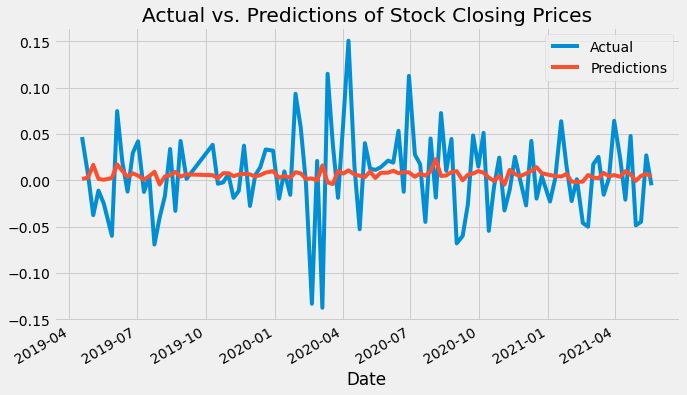

In [197]:
test_tuned_df.plot(title='Actual vs. Predictions of Stock Closing Prices')